Import everything that is needed

In [1]:
import numpy as np
import pandas as pd
import gensim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from myfuncs import *

%matplotlib inline

Read training data  
Group tweets by sentiment for the WordCloud graph  
Clean the data

In [ ]:
df = pd.read_csv("../twitter_data/train2017.tsv",engine = 'python',sep = '\t+', header = None)

#group tweets by sentiment
emot = df.groupby(2)
pos = emot.get_group("positive")
neg = emot.get_group("negative")
neut = emot.get_group("neutral")

#clean-up the tweets
pos_words = cleanup(pos[3])
neg_words = cleanup(neg[3])
neut_words = cleanup(neut[3])


clean_pos_text = " ".join(pos_words)
clean_neg_text = " ".join(neg_words)
clean_neut_text = " ".join(neut_words)
clean_overall_text = clean_pos_text + " " + clean_neg_text + " " + clean_neut_text

WordCould graphs for most frequent words in positive, negative, neutral and overall tweets

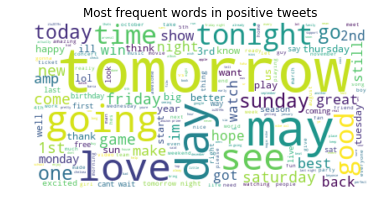

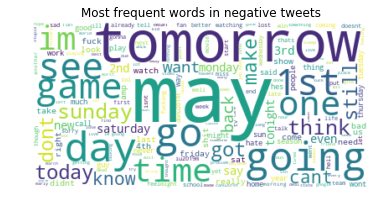

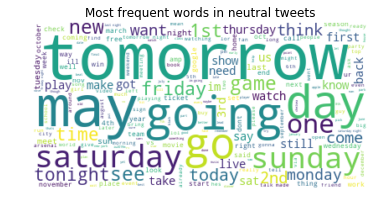

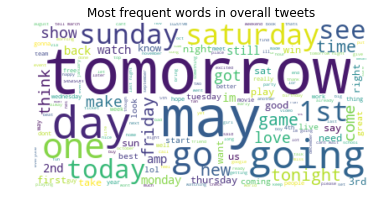

In [3]:
show_WordCloud(clean_pos_text,"positive")
show_WordCloud(clean_neg_text,"negative")
show_WordCloud(clean_neut_text,"neutral")
show_WordCloud(clean_overall_text,"overall")

Convert training tweets to vectors(Bag-of-Words, TF-IDF, Word2Vec)

In [14]:
corpus = pos_words + neg_words + neut_words

vectorizer = CountVectorizer(max_features=1000)
BOW_array = vectorizer.fit_transform(corpus)

TFIDF_vectorizer = TfidfVectorizer(max_features=1000)
TFIDF_array = TFIDF_vectorizer.fit_transform(corpus)

mytweets = pd.DataFrame(corpus)
tokenized_tweet = mytweets[0][:].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(mytweets), epochs=20)

w2v_array = w2varray_mean(model_w2v,corpus) #covert tweet to vector with constant length

T-SNE plot of the Word2Vec model  
Remove comment to run(takes a lot of time)

In [5]:
#tsne_plot(model_w2v)

Read the testing data and clean them up

In [7]:
df2 = pd.read_csv("../twitter_data/test2017.tsv",engine = 'python',sep = '\t+',header = None)

#clean-up the tweets
clean_test = cleanup(df2[3])

Convert testing tweets to vectors(Bag-of-Words, TF-IDF, Word2Vec)

In [15]:
vectorizer = CountVectorizer(max_features=1000)
BOW_array_test = vectorizer.fit_transform(clean_test)

TFIDF_vectorizer = TfidfVectorizer(max_features=1000)
TFIDF_array_test = TFIDF_vectorizer.fit_transform(clean_test)

mytweets = pd.DataFrame(clean_test)

tokenized_tweet = mytweets[0][:].apply(lambda x: x.split()) # tokenizing

model_w2v_test = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v_test.train(tokenized_tweet, total_examples= len(mytweets), epochs=20)

w2v_array_test = w2varray_mean(model_w2v_test,clean_test) #covert tweet to vector with constant length

Create array of the sentimental values of the training tweets  
Read the correct sentimental value of the testing tweets

In [11]:
pos_array = np.full(pos[2].shape, 0)
neg_array = np.full(neg[2].shape, 1)
neut_array = np.full(neut[2].shape, 2)

val_actual = np.concatenate((pos_array, neg_array, neut_array))

df3 = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt",engine = 'python',sep = '\t+', header = None)

df3.loc[(df3[1] == "positive"),1] = 0
df3.loc[(df3[1] == "negative"),1] = 1
df3.loc[(df3[1] == "neutral"),1] = 2
test_actual = df3[1].to_numpy()

Classify the data with KNN classifier

In [12]:
#--------------------KNN classifiers--------------------
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(BOW_array, val_actual)
pred1 = knn1.predict(BOW_array_test)

knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(TFIDF_array, val_actual)
pred2 = knn2.predict(TFIDF_array_test)

knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(w2v_array, val_actual)
pred3 = knn3.predict(w2v_array_test)

score1 = f1_score(test_actual, pred1, average='macro') #evaluate on the validation set
score2 = f1_score(test_actual, pred2, average='macro') #evaluate on the validation set
score3 = f1_score(test_actual, pred3, average='macro') #evaluate on the validation set

print("----------KNN----------")
print("Bag-of-Words: ", score1)
print("TF-IDF: ", score2)
print("W2V: ", score3)

----------KNN----------
Bag-of-Words:  0.3167784620018854
TF-IDF:  0.30846775402156745
W2V:  0.26011847303745755


Classify the data with SVM classifier

In [ ]:
# --------------------SVM classifiers--------------------
svm1 = SVC(kernel='linear', C=1, probability=True)
svm1.fit(BOW_array, val_actual)
pred1 = svm1.predict(BOW_array_test)

svm2 = SVC(kernel='linear', C=1, probability=True)
svm2.fit(TFIDF_array, val_actual)
pred2 = svm2.predict(TFIDF_array_test)

svm3 = SVC(kernel='linear', C=1, probability=True)
svm3.fit(w2v_array, val_actual)
pred3 = svm3.predict(w2v_array_test)

score1 = f1_score(test_actual, pred1, average='macro') #evaluate on the validation set
score2 = f1_score(test_actual, pred2, average='macro') #evaluate on the validation set
score3 = f1_score(test_actual, pred3, average='macro') #evaluate on the validation set

print("----------SVM----------")
print("Bag-of-Words: ", score1)
print("TF-IDF: ", score2)
print("W2V: ", score3)